# This notebook plots composite MCS evolution over a specified region and period

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
%matplotlib inline

In [2]:
# Dictionary for official model names
model_name = {
    'obs': 'OBS',
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

# Region
region = 'tropics'
lon_bounds = [0, 360]
lat_bounds = [-20, 15]
# MCS lifetime range
lifetime_bounds = [2,60]
# MCS initiation date range
sdate = '2020-01-25T00'
edate = '2020-02-27T00'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

test = ''
# test = '_ccs1_2h'
rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/'
obsfile = f'{obsdir}mcs_tracks_final_20200120.0000_20200301.0000.nc'

name_map = {
    'obs': 'obs',
    'm1': 'mpi',
    'm2': 'scream',
    'm3': 'nasa',
    'm4': 'nicam',
    'm5': 'noaa',
    'm6': 'uk',
}
m1dir = f'{rootdir}{name_map["m1"]}/stats{test}/'
m2dir = f'{rootdir}{name_map["m2"]}/stats{test}/'
m3dir = f'{rootdir}{name_map["m3"]}/stats{test}/'
m4dir = f'{rootdir}{name_map["m4"]}/stats{test}/'
m5dir = f'{rootdir}{name_map["m5"]}/stats{test}/'
m6dir = f'{rootdir}{name_map["m6"]}/stats{test}/'
m1file = f'{m1dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m2file = f'{m2dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m3file = f'{m3dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m4file = f'{m4dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m5file = f'{m5dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'
m6file = f'{m6dir}mcs_tracks_final_20200120.0000_20200301.0000.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/


In [3]:
obsfile, m1file, m2file, m3file, m4file, m5file, m6file

('/global/cfs/cdirs/m1867/zfeng/dyamond-winter/obs/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/mpi/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/scream/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nasa/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nicam/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/noaa/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/uk/stats/mcs_tracks_final_20200120.0000_20200301.0000.nc')

## Custom functions for track selections

In [4]:
def find_track_in_region(start_basetime, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track initiation location
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_basetime >= pd.to_datetime(sdate)) & (start_basetime <= pd.to_datetime(edate)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds))
    )[0]
    return mcsidx

def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Subset tracks from Dataset
    ds = ds.isel(tracks=trackidx)

    # Calculate lifetime-mean PF land fraction
    init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds['pf_landfrac'].mean(dim='times')
    # Separate land vs. ocean tracks
    mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
    mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
    # Subset tracks for land vs. ocean
    ds_l = ds.isel(tracks=mcsidx_land)
    ds_o = ds.isel(tracks=mcsidx_ocean)    
    return (ds_l, ds_o)

def find_merge_split_tracks(ds):
    """
    Find merge/split track indices.
    """
    # non-split tracks
    idx_nsplit = np.isnan(ds.start_split_cloudnumber)
    # non-merge tracks
    idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
    # non-merge and non-split tracks
    idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
    # merge or split tracks
    idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
    # Group outputs to dictionary
    out_dict = {
        'ms': idx_ms,
        'nms': idx_nms,
        'nm': idx_nmerge,
        'ns': idx_nsplit,
    }
    return out_dict

In [5]:
# Read OBS MCS data
dsobs = xr.open_dataset(obsfile)
time_res_obs = dsobs.attrs['time_resolution_hour']
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
dsobs

<xarray.Dataset>
Dimensions:                  (tracks: 3068, times: 200, mergers: 200, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 3064 3065 3066 3067
  * times                    (times) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * mergers                  (mergers) int64 0 1 2 3 4 5 ... 195 196 197 198 199
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Sat Feb 12 17:42:48 2022
    startdate:                   20200120.0000
    enddate:                     20200301.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [6]:
# Read m1 data
dsm1 = xr.open_dataset(m1file)
time_res_m1 = dsm1.attrs['time_resolution_hour']
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']

In [7]:
# Read m2 data
dsm2 = xr.open_dataset(m2file)
time_res_m2 = dsm2.attrs['time_resolution_hour']
pixel_radius_m2 = dsm2.attrs['pixel_radius_km']

In [8]:
# Read m3 data
dsm3 = xr.open_dataset(m3file)
time_res_m3 = dsm3.attrs['time_resolution_hour']
pixel_radius_m3 = dsm3.attrs['pixel_radius_km']

In [9]:
# Read m4 data
dsm4 = xr.open_dataset(m4file)
time_res_m4 = dsm4.attrs['time_resolution_hour']
pixel_radius_m4 = dsm4.attrs['pixel_radius_km']

In [10]:
# Read m5 data
dsm5 = xr.open_dataset(m5file)
time_res_m5 = dsm5.attrs['time_resolution_hour']
pixel_radius_m5 = dsm5.attrs['pixel_radius_km']

In [11]:
# Read m6 data
dsm6 = xr.open_dataset(m6file)
time_res_m6 = dsm6.attrs['time_resolution_hour']
pixel_radius_m6 = dsm6.attrs['pixel_radius_km']

## Find tracks by time, region, lifetime

In [12]:
# OBS
mcsidx_obs = find_track_in_region(dsobs.start_basetime, dsobs.meanlon, dsobs.meanlat, dsobs.track_duration*time_res_obs, lon_bounds, lat_bounds, lifetime_bounds)
print('Number of MCS (OBS): ', len(mcsidx_obs))

# Model m1
mcsidx_m1 = find_track_in_region(dsm1.start_basetime, dsm1.meanlon, dsm1.meanlat, dsm1.track_duration*time_res_m1, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m1"]}): ', len(mcsidx_m1))

# Model m2
mcsidx_m2 = find_track_in_region(dsm2.start_basetime, dsm2.meanlon, dsm2.meanlat, dsm2.track_duration*time_res_m2, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m2"]}): ', len(mcsidx_m2))

# Model m3
mcsidx_m3 = find_track_in_region(dsm3.start_basetime, dsm3.meanlon, dsm3.meanlat, dsm3.track_duration*time_res_m3, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m3"]}): ', len(mcsidx_m3))

# Model m4
mcsidx_m4 = find_track_in_region(dsm4.start_basetime, dsm4.meanlon, dsm4.meanlat, dsm4.track_duration*time_res_m4, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m4"]}): ', len(mcsidx_m4))

# Model m5
mcsidx_m5 = find_track_in_region(dsm5.start_basetime, dsm5.meanlon, dsm5.meanlat, dsm5.track_duration*time_res_m5, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m5"]}): ', len(mcsidx_m5))

# Model m6
mcsidx_m6 = find_track_in_region(dsm6.start_basetime, dsm6.meanlon, dsm6.meanlat, dsm6.track_duration*time_res_m6, lon_bounds, lat_bounds, lifetime_bounds)
print(f'Number of MCS ({name_map["m6"]}): ', len(mcsidx_m6))

Number of MCS (OBS):  1808
Number of MCS (mpi):  1405
Number of MCS (scream):  1500
Number of MCS (nasa):  4208
Number of MCS (nicam):  4596
Number of MCS (noaa):  4208
Number of MCS (uk):  3703


In [13]:
# def get_land_ocean_ds(ds, trackidx, land_frac_thresh, ocean_frac_thresh):
#     # Subset tracks from Dataset
#     ds = ds.isel(tracks=trackidx)

#     # Calculate lifetime-mean PF land fraction
#     init_landfrac = ds['pf_landfrac'].isel(times=slice(0,3)).mean(dim='times')
#     avg_landfrac = ds['pf_landfrac'].mean(dim='times')
#     # Separate land vs. ocean tracks
#     mcsidx_land = np.where(avg_landfrac > land_frac_thresh)[0]
#     mcsidx_ocean = np.where(avg_landfrac < ocean_frac_thresh)[0]
#     # Subset tracks for land vs. ocean
#     ds_l = ds.isel(tracks=mcsidx_land)
#     ds_o = ds.isel(tracks=mcsidx_ocean)
    
#     return (ds_l, ds_o)

## Separate land vs. ocean MCS

In [14]:
# Separate land vs. ocean MCS
ds_l_obs, ds_o_obs = get_land_ocean_ds(dsobs, mcsidx_obs, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS (OBS): {ds_l_obs.dims['tracks']}, Number of ocean MCS (OBS): {ds_o_obs.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m1, ds_o_m1 = get_land_ocean_ds(dsm1, mcsidx_m1, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m1']}): {ds_l_m1.dims['tracks']}, Number of ocean MCS ({name_map['m1']}): {ds_o_m1.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m2, ds_o_m2 = get_land_ocean_ds(dsm2, mcsidx_m2, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m2']}): {ds_l_m2.dims['tracks']}, Number of ocean MCS ({name_map['m2']}): {ds_o_m2.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m3, ds_o_m3 = get_land_ocean_ds(dsm3, mcsidx_m3, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m3']}): {ds_l_m3.dims['tracks']}, Number of ocean MCS ({name_map['m3']}): {ds_o_m3.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m4, ds_o_m4 = get_land_ocean_ds(dsm4, mcsidx_m4, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m4']}): {ds_l_m4.dims['tracks']}, Number of ocean MCS ({name_map['m4']}): {ds_o_m4.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m5, ds_o_m5 = get_land_ocean_ds(dsm5, mcsidx_m5, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m5']}): {ds_l_m5.dims['tracks']}, Number of ocean MCS ({name_map['m5']}): {ds_o_m5.dims['tracks']}")

# Separate land vs. ocean MCS
ds_l_m6, ds_o_m6 = get_land_ocean_ds(dsm6, mcsidx_m6, land_frac_thresh, ocean_frac_thresh)
print(f"Number of land MCS ({name_map['m6']}): {ds_l_m6.dims['tracks']}, Number of ocean MCS ({name_map['m6']}): {ds_o_m6.dims['tracks']}")

Number of land MCS (OBS): 565, Number of ocean MCS (OBS): 931
Number of land MCS (mpi): 591, Number of ocean MCS (mpi): 479
Number of land MCS (scream): 497, Number of ocean MCS (scream): 677
Number of land MCS (nasa): 1883, Number of ocean MCS (nasa): 1918
Number of land MCS (nicam): 1110, Number of ocean MCS (nicam): 2777
Number of land MCS (noaa): 1339, Number of ocean MCS (noaa): 2252
Number of land MCS (uk): 1467, Number of ocean MCS (uk): 1724


## Find merge/split track indices

In [15]:
# def find_merge_split_tracks(ds):
#     # non-split tracks
#     idx_nsplit = np.isnan(ds.start_split_cloudnumber)
#     # non-merge tracks
#     idx_nmerge = np.isnan(ds.end_merge_cloudnumber)
#     # non-merge and non-split tracks
#     idx_nms = np.isnan(ds.start_split_cloudnumber) & np.isnan(ds.end_merge_cloudnumber)
#     # merge or split tracks
#     idx_ms = ~np.isnan(ds.start_split_cloudnumber) | ~np.isnan(ds.end_merge_cloudnumber)
#     # Group outputs to dictionary
#     out_dict = {
#         'ms': idx_ms,
#         'nms': idx_nms,
#         'nm': idx_nmerge,
#         'ns': idx_nsplit,
#     }
#     return out_dict

In [16]:
tid_o_obs = find_merge_split_tracks(ds_o_obs)
tid_l_obs = find_merge_split_tracks(ds_l_obs)

tid_o_m1 = find_merge_split_tracks(ds_o_m1)
tid_l_m1 = find_merge_split_tracks(ds_l_m1)

tid_o_m2 = find_merge_split_tracks(ds_o_m2)
tid_l_m2 = find_merge_split_tracks(ds_l_m2)

tid_o_m3 = find_merge_split_tracks(ds_o_m3)
tid_l_m3 = find_merge_split_tracks(ds_l_m3)

tid_o_m4 = find_merge_split_tracks(ds_o_m4)
tid_l_m4 = find_merge_split_tracks(ds_l_m4)

tid_o_m5 = find_merge_split_tracks(ds_o_m5)
tid_l_m5 = find_merge_split_tracks(ds_l_m5)

tid_o_m6 = find_merge_split_tracks(ds_o_m6)
tid_l_m6 = find_merge_split_tracks(ds_l_m6)

(array([ 32., 123., 118.,  85.,  64.,  48.,  36.,  20.,  14.,  11.,   6.,
          5.,  10.,   8.,   2.,   7.,   4.,   2.,   1.]),
 array([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39.,
        42., 45., 48., 51., 54., 57., 60.]),
 <BarContainer object of 19 artists>)

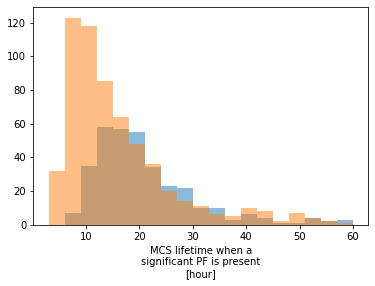

In [17]:
bins = np.arange(3,60.1,3)
ds_o_obs.isel(tracks=tid_o_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)
ds_o_obs.isel(tracks=tid_o_obs['ms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)

(array([ 1.,  5., 10.,  9.,  7.,  8.,  2.,  1.,  3.,  2.,  3.,  5.,  2.,
         1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39.,
        42., 45., 48., 51., 54., 57., 60.]),
 <BarContainer object of 19 artists>)

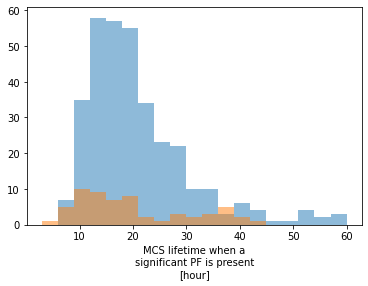

In [18]:
bins = np.arange(3,60.1,3)
ds_o_obs.isel(tracks=tid_o_obs['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)
ds_o_m1.isel(tracks=tid_o_m1['nms']).pf_lifetime.plot.hist(bins=bins, alpha=0.5)

## Subset merge/split tracks

In [19]:
ds_nms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['nms'])
ds_nms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['nms'])
ds_ms_o_obs = ds_o_obs.isel(tracks=tid_o_obs['ms'])
ds_ms_l_obs = ds_l_obs.isel(tracks=tid_l_obs['ms'])

In [20]:
ds_nms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['nms'])
ds_nms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['nms'])
ds_ms_o_m1 = ds_o_m1.isel(tracks=tid_o_m1['ms'])
ds_ms_l_m1 = ds_l_m1.isel(tracks=tid_l_m1['ms'])

In [21]:
ds_nms_o_m2 = ds_o_m2.isel(tracks=tid_o_m2['nms'])
ds_nms_l_m2 = ds_l_m2.isel(tracks=tid_l_m2['nms'])
ds_ms_o_m2 = ds_o_m2.isel(tracks=tid_o_m2['ms'])
ds_ms_l_m2 = ds_l_m2.isel(tracks=tid_l_m2['ms'])

In [22]:
ds_nms_o_m3 = ds_o_m3.isel(tracks=tid_o_m3['nms'])
ds_nms_l_m3 = ds_l_m3.isel(tracks=tid_l_m3['nms'])
ds_ms_o_m3 = ds_o_m3.isel(tracks=tid_o_m3['ms'])
ds_ms_l_m3 = ds_l_m3.isel(tracks=tid_l_m3['ms'])

In [23]:
ds_nms_o_m4 = ds_o_m4.isel(tracks=tid_o_m4['nms'])
ds_nms_l_m4 = ds_l_m4.isel(tracks=tid_l_m4['nms'])
ds_ms_o_m4 = ds_o_m4.isel(tracks=tid_o_m4['ms'])
ds_ms_l_m4 = ds_l_m4.isel(tracks=tid_l_m4['ms'])

In [24]:
ds_nms_o_m5 = ds_o_m5.isel(tracks=tid_o_m5['nms'])
ds_nms_l_m5 = ds_l_m5.isel(tracks=tid_l_m5['nms'])
ds_ms_o_m5 = ds_o_m5.isel(tracks=tid_o_m5['ms'])
ds_ms_l_m5 = ds_l_m5.isel(tracks=tid_l_m5['ms'])

In [25]:
ds_nms_o_m6 = ds_o_m6.isel(tracks=tid_o_m6['nms'])
ds_nms_l_m6 = ds_l_m6.isel(tracks=tid_l_m6['nms'])
ds_ms_o_m6 = ds_o_m6.isel(tracks=tid_o_m6['ms'])
ds_ms_l_m6 = ds_l_m6.isel(tracks=tid_l_m6['ms'])

In [26]:
# ccslifetime_o_obs = ds_o_obs.track_duration * time_res_obs
# lifetime_o_obs = ds_o_obs.pf_lifetime
# # Add mergers/splits to get total CCS area
# ccsarea_o_obs = ds_o_obs.ccs_area + ds_o_obs.merge_ccs_area.sum(dim='mergers') + ds_o_obs.split_ccs_area.sum(dim='mergers')
# ccsdiam_o_obs = 2 * np.sqrt(ccsarea_o_obs / np.pi)
# mintb_o_obs = ds_o_obs.corecold_mintb
# mcsstatus_o_obs = ds_o_obs.mcs_status
# # startstatus_o_obs = ds_o_obs.start_status
# # endstatus_o_obs = ds_o_obs.end_status
# start_split_cn_o_obs = ds_o_obs.start_split_cloudnumber
# end_merge_cn_o_obs = ds_o_obs.end_merge_cloudnumber

# # All PF area (sum over nmaxpf dimension)
# pfarea_o_obs = ds_o_obs.pf_area.sum(dim='nmaxpf')
# # Largest PF area
# pfarea_largest_o_obs = ds_o_obs.pf_area.isel(nmaxpf=0)
# pfdiam_o_obs = 2 * np.sqrt(pfarea_largest_o_obs / np.pi)
# # Lifetime maximum
# maxpfdiam_o_obs = pfdiam_o_obs.max(dim='times')

# pfrainrate_o_obs = ds_o_obs.pf_rainrate.isel(nmaxpf=0)
# pfaccumrain_o_obs = ds_o_obs.pf_accumrain.sum(dim='nmaxpf')
# maxpfrainrate_o_obs = pfrainrate_o_obs.max(dim='times')
# meanpfrainrate_o_obs = pfrainrate_o_obs.mean(dim='times')

# # Compute volume rainrate [unit: kg/h]
# pfvolrain_o_obs = (ds_o_obs.total_rain * pixel_radius_obs**2)
# pfvolrainheavy_o_obs = (ds_o_obs.total_heavyrain * pixel_radius_obs**2)

## Function to composite track time-evolution by 1 condition

In [27]:
import warnings
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, quantiles):
    # Suppress RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Filter by one condition range
        in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]), drop=True)
        nsamples = in_var_cond.sizes['tracks']
        out_var_mean = in_var_cond.mean(dim='tracks')
        out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

# Composite time-evolution of MCS parameters by lifetime

In [53]:
# Set composite quantiles and lifetime range
quantiles = [0.25, 0.5, 0.75]
lifetime_range1 = [8, 14]
lifetime_range2 = [20, 24]

#### CCS lifetime and area (ocean)

In [54]:
# CCS lifetime
ccslifetime_o_obs = ds_nms_o_obs.track_duration*time_res_obs
ccslifetime_o_m1 = ds_nms_o_m1.track_duration*time_res_m1
ccslifetime_o_m2 = ds_nms_o_m2.track_duration*time_res_m2
ccslifetime_o_m3 = ds_nms_o_m3.track_duration*time_res_m3
ccslifetime_o_m4 = ds_nms_o_m4.track_duration*time_res_m4
ccslifetime_o_m5 = ds_nms_o_m5.track_duration*time_res_m5
ccslifetime_o_m6 = ds_nms_o_m6.track_duration*time_res_m6
# Add mergers/splits to get total CCS area
ccsarea_o_obs = ds_nms_o_obs.ccs_area + ds_nms_o_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_o_obs.split_ccs_area.sum(dim='mergers')
ccsarea_o_m1 = ds_nms_o_m1.ccs_area + ds_nms_o_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m1.split_ccs_area.sum(dim='mergers')
ccsarea_o_m2 = ds_nms_o_m2.ccs_area + ds_nms_o_m2.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m2.split_ccs_area.sum(dim='mergers')
ccsarea_o_m3 = ds_nms_o_m3.ccs_area + ds_nms_o_m3.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m3.split_ccs_area.sum(dim='mergers')
ccsarea_o_m4 = ds_nms_o_m4.ccs_area + ds_nms_o_m4.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m4.split_ccs_area.sum(dim='mergers')
ccsarea_o_m5 = ds_nms_o_m5.ccs_area + ds_nms_o_m5.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m5.split_ccs_area.sum(dim='mergers')
ccsarea_o_m6 = ds_nms_o_m6.ccs_area + ds_nms_o_m6.merge_ccs_area.sum(dim='mergers') + ds_nms_o_m6.split_ccs_area.sum(dim='mergers')

avg1_ccsarea_o_obs, qntl1_ccsarea_o_obs, ns1_o_obs = get_comp_tracks_by1cond(ccsarea_o_obs, ccslifetime_o_obs, lifetime_range1, quantiles)
avg1_ccsarea_o_m1, qntl1_ccsarea_o_m1, ns1_o_m1 = get_comp_tracks_by1cond(ccsarea_o_m1, ccslifetime_o_m1, lifetime_range1, quantiles)
avg1_ccsarea_o_m2, qntl1_ccsarea_o_m2, ns1_o_m2 = get_comp_tracks_by1cond(ccsarea_o_m2, ccslifetime_o_m2, lifetime_range1, quantiles)
avg1_ccsarea_o_m3, qntl1_ccsarea_o_m3, ns1_o_m3 = get_comp_tracks_by1cond(ccsarea_o_m3, ccslifetime_o_m3, lifetime_range1, quantiles)
avg1_ccsarea_o_m4, qntl1_ccsarea_o_m4, ns1_o_m4 = get_comp_tracks_by1cond(ccsarea_o_m4, ccslifetime_o_m4, lifetime_range1, quantiles)
avg1_ccsarea_o_m5, qntl1_ccsarea_o_m5, ns1_o_m5 = get_comp_tracks_by1cond(ccsarea_o_m5, ccslifetime_o_m5, lifetime_range1, quantiles)
avg1_ccsarea_o_m6, qntl1_ccsarea_o_m6, ns1_o_m6 = get_comp_tracks_by1cond(ccsarea_o_m6, ccslifetime_o_m6, lifetime_range1, quantiles)

avg2_ccsarea_o_obs, qntl2_ccsarea_o_obs, ns2_o_obs = get_comp_tracks_by1cond(ccsarea_o_obs, ccslifetime_o_obs, lifetime_range2, quantiles)
avg2_ccsarea_o_m1, qntl2_ccsarea_o_m1, ns2_o_m1 = get_comp_tracks_by1cond(ccsarea_o_m1, ccslifetime_o_m1, lifetime_range2, quantiles)
avg2_ccsarea_o_m2, qntl2_ccsarea_o_m2, ns2_o_m2 = get_comp_tracks_by1cond(ccsarea_o_m2, ccslifetime_o_m2, lifetime_range2, quantiles)
avg2_ccsarea_o_m3, qntl2_ccsarea_o_m3, ns2_o_m3 = get_comp_tracks_by1cond(ccsarea_o_m3, ccslifetime_o_m3, lifetime_range2, quantiles)
avg2_ccsarea_o_m4, qntl2_ccsarea_o_m4, ns2_o_m4 = get_comp_tracks_by1cond(ccsarea_o_m4, ccslifetime_o_m4, lifetime_range2, quantiles)
avg2_ccsarea_o_m5, qntl2_ccsarea_o_m5, ns2_o_m5 = get_comp_tracks_by1cond(ccsarea_o_m5, ccslifetime_o_m5, lifetime_range2, quantiles)
avg2_ccsarea_o_m6, qntl2_ccsarea_o_m6, ns2_o_m6 = get_comp_tracks_by1cond(ccsarea_o_m6, ccslifetime_o_m6, lifetime_range2, quantiles)

print(f'Samples1: obs ({ns1_o_obs}), m1 ({ns1_o_m1}), m2 ({ns1_o_m2}), m3 ({ns1_o_m3}), m4 ({ns1_o_m4}), m5 ({ns1_o_m5}), m6 ({ns1_o_m6})')
print(f'Samples2: obs ({ns2_o_obs}), m1 ({ns2_o_m2}), m2 ({ns2_o_m2}), m3 ({ns2_o_m3}), m4 ({ns2_o_m4}), m5 ({ns2_o_m5}), m6 ({ns2_o_m6})')

Samples1: obs (50), m1 (8), m2 (129), m3 (413), m4 (287), m5 (315), m6 (211)
Samples2: obs (80), m1 (52), m2 (52), m3 (73), m4 (78), m5 (80), m6 (83)


#### CCS lifetime and area (land)

In [55]:
# CCS lifetime
ccslifetime_l_obs = ds_nms_l_obs.track_duration*time_res_obs
ccslifetime_l_m1 = ds_nms_l_m1.track_duration*time_res_m1
ccslifetime_l_m2 = ds_nms_l_m2.track_duration*time_res_m2
ccslifetime_l_m3 = ds_nms_l_m3.track_duration*time_res_m3
ccslifetime_l_m4 = ds_nms_l_m4.track_duration*time_res_m4
ccslifetime_l_m5 = ds_nms_l_m5.track_duration*time_res_m5
ccslifetime_l_m6 = ds_nms_l_m6.track_duration*time_res_m6
# Add mergers/splits to get total CCS area
ccsarea_l_obs = ds_nms_l_obs.ccs_area + ds_nms_l_obs.merge_ccs_area.sum(dim='mergers') + ds_nms_l_obs.split_ccs_area.sum(dim='mergers')
ccsarea_l_m1 = ds_nms_l_m1.ccs_area + ds_nms_l_m1.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m1.split_ccs_area.sum(dim='mergers')
ccsarea_l_m2 = ds_nms_l_m2.ccs_area + ds_nms_l_m2.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m2.split_ccs_area.sum(dim='mergers')
ccsarea_l_m3 = ds_nms_l_m3.ccs_area + ds_nms_l_m3.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m3.split_ccs_area.sum(dim='mergers')
ccsarea_l_m4 = ds_nms_l_m4.ccs_area + ds_nms_l_m4.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m4.split_ccs_area.sum(dim='mergers')
ccsarea_l_m5 = ds_nms_l_m5.ccs_area + ds_nms_l_m5.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m5.split_ccs_area.sum(dim='mergers')
ccsarea_l_m6 = ds_nms_l_m6.ccs_area + ds_nms_l_m6.merge_ccs_area.sum(dim='mergers') + ds_nms_l_m6.split_ccs_area.sum(dim='mergers')

avg1_ccsarea_l_obs, qntl1_ccsarea_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ccsarea_l_obs, ccslifetime_l_obs, lifetime_range1, quantiles)
avg1_ccsarea_l_m1, qntl1_ccsarea_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ccsarea_l_m1, ccslifetime_l_m1, lifetime_range1, quantiles)
avg1_ccsarea_l_m2, qntl1_ccsarea_l_m2, ns1_l_m2 = get_comp_tracks_by1cond(ccsarea_l_m2, ccslifetime_l_m2, lifetime_range1, quantiles)
avg1_ccsarea_l_m3, qntl1_ccsarea_l_m3, ns1_l_m3 = get_comp_tracks_by1cond(ccsarea_l_m3, ccslifetime_l_m3, lifetime_range1, quantiles)
avg1_ccsarea_l_m4, qntl1_ccsarea_l_m4, ns1_l_m4 = get_comp_tracks_by1cond(ccsarea_l_m4, ccslifetime_l_m4, lifetime_range1, quantiles)
avg1_ccsarea_l_m5, qntl1_ccsarea_l_m5, ns1_l_m5 = get_comp_tracks_by1cond(ccsarea_l_m5, ccslifetime_l_m5, lifetime_range1, quantiles)
avg1_ccsarea_l_m6, qntl1_ccsarea_l_m6, ns1_l_m6 = get_comp_tracks_by1cond(ccsarea_l_m6, ccslifetime_l_m6, lifetime_range1, quantiles)

avg2_ccsarea_l_obs, qntl2_ccsarea_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ccsarea_l_obs, ccslifetime_l_obs, lifetime_range2, quantiles)
avg2_ccsarea_l_m1, qntl2_ccsarea_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ccsarea_l_m1, ccslifetime_l_m1, lifetime_range2, quantiles)
avg2_ccsarea_l_m2, qntl2_ccsarea_l_m2, ns2_l_m2 = get_comp_tracks_by1cond(ccsarea_l_m2, ccslifetime_l_m2, lifetime_range2, quantiles)
avg2_ccsarea_l_m3, qntl2_ccsarea_l_m3, ns2_l_m3 = get_comp_tracks_by1cond(ccsarea_l_m3, ccslifetime_l_m3, lifetime_range2, quantiles)
avg2_ccsarea_l_m4, qntl2_ccsarea_l_m4, ns2_l_m4 = get_comp_tracks_by1cond(ccsarea_l_m4, ccslifetime_l_m4, lifetime_range2, quantiles)
avg2_ccsarea_l_m5, qntl2_ccsarea_l_m5, ns2_l_m5 = get_comp_tracks_by1cond(ccsarea_l_m5, ccslifetime_l_m5, lifetime_range2, quantiles)
avg2_ccsarea_l_m6, qntl2_ccsarea_l_m6, ns2_l_m6 = get_comp_tracks_by1cond(ccsarea_l_m6, ccslifetime_l_m6, lifetime_range2, quantiles)

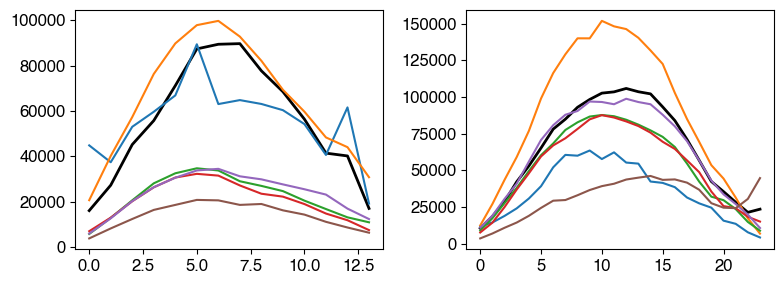

In [56]:
xx_obs = avg1_ccsarea_o_obs.times
xx_m1 = avg1_ccsarea_o_m1.times
xx_m2 = avg1_ccsarea_o_m2.times
xx_m3 = avg1_ccsarea_o_m2.times
xx_m4 = avg1_ccsarea_o_m2.times
xx_m5 = avg1_ccsarea_o_m2.times
xx_m6 = avg1_ccsarea_o_m2.times

fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_ccsarea_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg1_ccsarea_o_m1)
ax.plot(xx_m2, avg1_ccsarea_o_m2)
ax.plot(xx_m3, avg1_ccsarea_o_m3)
ax.plot(xx_m4, avg1_ccsarea_o_m4)
ax.plot(xx_m5, avg1_ccsarea_o_m5)
ax.plot(xx_m6, avg1_ccsarea_o_m6)
ax = axes[1]
plt.plot(xx_obs, avg2_ccsarea_o_obs, 'k', lw=2)
plt.plot(xx_m1, avg2_ccsarea_o_m1)
plt.plot(xx_m2, avg2_ccsarea_o_m2)
plt.plot(xx_m3, avg2_ccsarea_o_m3)
plt.plot(xx_m4, avg2_ccsarea_o_m4)
plt.plot(xx_m5, avg2_ccsarea_o_m5)
plt.plot(xx_m6, avg2_ccsarea_o_m6)
fig.tight_layout()

#### Min Tb (ocean)

In [57]:
avg1_mintb_o_obs, qntl1_mintb_o_obs, ns1_o_obs = get_comp_tracks_by1cond(ds_nms_o_obs.corecold_mintb, ccslifetime_o_obs, lifetime_range1, quantiles)
avg1_mintb_o_m1, qntl1_mintb_o_m1, ns1_o_m1 = get_comp_tracks_by1cond(ds_nms_o_m1.corecold_mintb, ccslifetime_o_m1, lifetime_range1, quantiles)
avg1_mintb_o_m2, qntl1_mintb_o_m2, ns1_o_m2 = get_comp_tracks_by1cond(ds_nms_o_m2.corecold_mintb, ccslifetime_o_m2, lifetime_range1, quantiles)
avg1_mintb_o_m3, qntl1_mintb_o_m3, ns1_o_m3 = get_comp_tracks_by1cond(ds_nms_o_m3.corecold_mintb, ccslifetime_o_m3, lifetime_range1, quantiles)
avg1_mintb_o_m4, qntl1_mintb_o_m4, ns1_o_m4 = get_comp_tracks_by1cond(ds_nms_o_m4.corecold_mintb, ccslifetime_o_m4, lifetime_range1, quantiles)
avg1_mintb_o_m5, qntl1_mintb_o_m5, ns1_o_m5 = get_comp_tracks_by1cond(ds_nms_o_m5.corecold_mintb, ccslifetime_o_m5, lifetime_range1, quantiles)
avg1_mintb_o_m6, qntl1_mintb_o_m6, ns1_o_m6 = get_comp_tracks_by1cond(ds_nms_o_m6.corecold_mintb, ccslifetime_o_m6, lifetime_range1, quantiles)

avg2_mintb_o_obs, qntl2_mintb_o_obs, ns2_o_obs = get_comp_tracks_by1cond(ds_nms_o_obs.corecold_mintb, ccslifetime_o_obs, lifetime_range2, quantiles)
avg2_mintb_o_m1, qntl2_mintb_o_m1, ns2_o_m1 = get_comp_tracks_by1cond(ds_nms_o_m1.corecold_mintb, ccslifetime_o_m1, lifetime_range2, quantiles)
avg2_mintb_o_m2, qntl2_mintb_o_m2, ns2_o_m2 = get_comp_tracks_by1cond(ds_nms_o_m2.corecold_mintb, ccslifetime_o_m2, lifetime_range2, quantiles)
avg2_mintb_o_m3, qntl2_mintb_o_m3, ns2_o_m3 = get_comp_tracks_by1cond(ds_nms_o_m3.corecold_mintb, ccslifetime_o_m3, lifetime_range2, quantiles)
avg2_mintb_o_m4, qntl2_mintb_o_m4, ns2_o_m4 = get_comp_tracks_by1cond(ds_nms_o_m4.corecold_mintb, ccslifetime_o_m4, lifetime_range2, quantiles)
avg2_mintb_o_m5, qntl2_mintb_o_m5, ns2_o_m5 = get_comp_tracks_by1cond(ds_nms_o_m5.corecold_mintb, ccslifetime_o_m5, lifetime_range2, quantiles)
avg2_mintb_o_m6, qntl2_mintb_o_m6, ns2_o_m6 = get_comp_tracks_by1cond(ds_nms_o_m6.corecold_mintb, ccslifetime_o_m6, lifetime_range2, quantiles)

#### Min Tb (land)

In [58]:
avg1_mintb_l_obs, qntl1_mintb_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.corecold_mintb, ccslifetime_l_obs, lifetime_range1, quantiles)
avg1_mintb_l_m1, qntl1_mintb_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.corecold_mintb, ccslifetime_l_m1, lifetime_range1, quantiles)
avg1_mintb_l_m2, qntl1_mintb_l_m2, ns1_l_m2 = get_comp_tracks_by1cond(ds_nms_l_m2.corecold_mintb, ccslifetime_l_m2, lifetime_range1, quantiles)
avg1_mintb_l_m3, qntl1_mintb_l_m3, ns1_l_m3 = get_comp_tracks_by1cond(ds_nms_l_m3.corecold_mintb, ccslifetime_l_m3, lifetime_range1, quantiles)
avg1_mintb_l_m4, qntl1_mintb_l_m4, ns1_l_m4 = get_comp_tracks_by1cond(ds_nms_l_m4.corecold_mintb, ccslifetime_l_m4, lifetime_range1, quantiles)
avg1_mintb_l_m5, qntl1_mintb_l_m5, ns1_l_m5 = get_comp_tracks_by1cond(ds_nms_l_m5.corecold_mintb, ccslifetime_l_m5, lifetime_range1, quantiles)
avg1_mintb_l_m6, qntl1_mintb_l_m6, ns1_l_m6 = get_comp_tracks_by1cond(ds_nms_l_m6.corecold_mintb, ccslifetime_l_m6, lifetime_range1, quantiles)

avg2_mintb_l_obs, qntl2_mintb_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.corecold_mintb, ccslifetime_l_obs, lifetime_range2, quantiles)
avg2_mintb_l_m1, qntl2_mintb_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.corecold_mintb, ccslifetime_l_m1, lifetime_range2, quantiles)
avg2_mintb_l_m2, qntl2_mintb_l_m2, ns2_l_m2 = get_comp_tracks_by1cond(ds_nms_l_m2.corecold_mintb, ccslifetime_l_m2, lifetime_range2, quantiles)
avg2_mintb_l_m3, qntl2_mintb_l_m3, ns2_l_m3 = get_comp_tracks_by1cond(ds_nms_l_m3.corecold_mintb, ccslifetime_l_m3, lifetime_range2, quantiles)
avg2_mintb_l_m4, qntl2_mintb_l_m4, ns2_l_m4 = get_comp_tracks_by1cond(ds_nms_l_m4.corecold_mintb, ccslifetime_l_m4, lifetime_range2, quantiles)
avg2_mintb_l_m5, qntl2_mintb_l_m5, ns2_l_m5 = get_comp_tracks_by1cond(ds_nms_l_m5.corecold_mintb, ccslifetime_l_m5, lifetime_range2, quantiles)
avg2_mintb_l_m6, qntl2_mintb_l_m6, ns2_l_m6 = get_comp_tracks_by1cond(ds_nms_l_m6.corecold_mintb, ccslifetime_l_m6, lifetime_range2, quantiles)

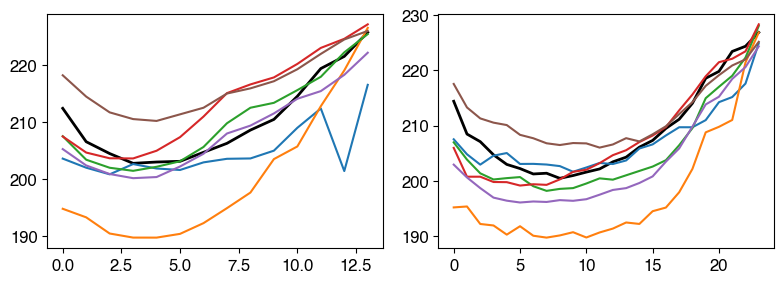

In [59]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_mintb_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg1_mintb_o_m1)
ax.plot(xx_m2, avg1_mintb_o_m2)
ax.plot(xx_m3, avg1_mintb_o_m3)
ax.plot(xx_m4, avg1_mintb_o_m4)
ax.plot(xx_m5, avg1_mintb_o_m5)
ax.plot(xx_m6, avg1_mintb_o_m6)
ax = axes[1]
plt.plot(xx_obs, avg2_mintb_o_obs, 'k', lw=2)
plt.plot(xx_m1, avg2_mintb_o_m1)
plt.plot(xx_m2, avg2_mintb_o_m2)
plt.plot(xx_m3, avg2_mintb_o_m3)
plt.plot(xx_m4, avg2_mintb_o_m4)
plt.plot(xx_m5, avg2_mintb_o_m5)
plt.plot(xx_m6, avg2_mintb_o_m6)
fig.tight_layout()

#### PF area (ocean)

In [60]:
# Largest PF area
avg1_pfarea_o_obs, qntl1_pfarea_o_obs, ns1_o_obs = get_comp_tracks_by1cond(ds_nms_o_obs.pf_area.isel(nmaxpf=0), ccslifetime_o_obs, lifetime_range1, quantiles)
avg1_pfarea_o_m1, qntl1_pfarea_o_m1, ns1_o_m1 = get_comp_tracks_by1cond(ds_nms_o_m1.pf_area.isel(nmaxpf=0), ccslifetime_o_m1, lifetime_range1, quantiles)
avg1_pfarea_o_m2, qntl1_pfarea_o_m2, ns1_o_m2 = get_comp_tracks_by1cond(ds_nms_o_m2.pf_area.isel(nmaxpf=0), ccslifetime_o_m2, lifetime_range1, quantiles)
avg1_pfarea_o_m3, qntl1_pfarea_o_m3, ns1_o_m3 = get_comp_tracks_by1cond(ds_nms_o_m3.pf_area.isel(nmaxpf=0), ccslifetime_o_m3, lifetime_range1, quantiles)
avg1_pfarea_o_m4, qntl1_pfarea_o_m4, ns1_o_m4 = get_comp_tracks_by1cond(ds_nms_o_m4.pf_area.isel(nmaxpf=0), ccslifetime_o_m4, lifetime_range1, quantiles)
avg1_pfarea_o_m5, qntl1_pfarea_o_m5, ns1_o_m5 = get_comp_tracks_by1cond(ds_nms_o_m5.pf_area.isel(nmaxpf=0), ccslifetime_o_m5, lifetime_range1, quantiles)
avg1_pfarea_o_m6, qntl1_pfarea_o_m6, ns1_o_m6 = get_comp_tracks_by1cond(ds_nms_o_m6.pf_area.isel(nmaxpf=0), ccslifetime_o_m6, lifetime_range1, quantiles)

avg2_pfarea_o_obs, qntl2_pfarea_o_obs, ns2_o_obs = get_comp_tracks_by1cond(ds_nms_o_obs.pf_area.isel(nmaxpf=0), ccslifetime_o_obs, lifetime_range2, quantiles)
avg2_pfarea_o_m1, qntl2_pfarea_o_m1, ns2_o_m1 = get_comp_tracks_by1cond(ds_nms_o_m1.pf_area.isel(nmaxpf=0), ccslifetime_o_m1, lifetime_range2, quantiles)
avg2_pfarea_o_m2, qntl2_pfarea_o_m2, ns2_o_m2 = get_comp_tracks_by1cond(ds_nms_o_m2.pf_area.isel(nmaxpf=0), ccslifetime_o_m2, lifetime_range2, quantiles)
avg2_pfarea_o_m3, qntl2_pfarea_o_m3, ns2_o_m3 = get_comp_tracks_by1cond(ds_nms_o_m3.pf_area.isel(nmaxpf=0), ccslifetime_o_m3, lifetime_range2, quantiles)
avg2_pfarea_o_m4, qntl2_pfarea_o_m4, ns2_o_m4 = get_comp_tracks_by1cond(ds_nms_o_m4.pf_area.isel(nmaxpf=0), ccslifetime_o_m4, lifetime_range2, quantiles)
avg2_pfarea_o_m5, qntl2_pfarea_o_m5, ns2_o_m5 = get_comp_tracks_by1cond(ds_nms_o_m5.pf_area.isel(nmaxpf=0), ccslifetime_o_m5, lifetime_range2, quantiles)
avg2_pfarea_o_m6, qntl2_pfarea_o_m6, ns2_o_m6 = get_comp_tracks_by1cond(ds_nms_o_m6.pf_area.isel(nmaxpf=0), ccslifetime_o_m6, lifetime_range2, quantiles)

#### PF area (land)

In [61]:
# Largest PF area
avg1_pfarea_l_obs, qntl1_pfarea_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_area.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range1, quantiles)
avg1_pfarea_l_m1, qntl1_pfarea_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_area.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range1, quantiles)
avg1_pfarea_l_m2, qntl1_pfarea_l_m2, ns1_l_m2 = get_comp_tracks_by1cond(ds_nms_l_m2.pf_area.isel(nmaxpf=0), ccslifetime_l_m2, lifetime_range1, quantiles)
avg1_pfarea_l_m3, qntl1_pfarea_l_m3, ns1_l_m3 = get_comp_tracks_by1cond(ds_nms_l_m3.pf_area.isel(nmaxpf=0), ccslifetime_l_m3, lifetime_range1, quantiles)
avg1_pfarea_l_m4, qntl1_pfarea_l_m4, ns1_l_m4 = get_comp_tracks_by1cond(ds_nms_l_m4.pf_area.isel(nmaxpf=0), ccslifetime_l_m4, lifetime_range1, quantiles)
avg1_pfarea_l_m5, qntl1_pfarea_l_m5, ns1_l_m5 = get_comp_tracks_by1cond(ds_nms_l_m5.pf_area.isel(nmaxpf=0), ccslifetime_l_m5, lifetime_range1, quantiles)
avg1_pfarea_l_m6, qntl1_pfarea_l_m6, ns1_l_m6 = get_comp_tracks_by1cond(ds_nms_l_m6.pf_area.isel(nmaxpf=0), ccslifetime_l_m6, lifetime_range1, quantiles)

avg2_pfarea_l_obs, qntl2_pfarea_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_area.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range2, quantiles)
avg2_pfarea_l_m1, qntl2_pfarea_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_area.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range2, quantiles)
avg2_pfarea_l_m2, qntl2_pfarea_l_m2, ns2_l_m2 = get_comp_tracks_by1cond(ds_nms_l_m2.pf_area.isel(nmaxpf=0), ccslifetime_l_m2, lifetime_range2, quantiles)
avg2_pfarea_l_m3, qntl2_pfarea_l_m3, ns2_l_m3 = get_comp_tracks_by1cond(ds_nms_l_m3.pf_area.isel(nmaxpf=0), ccslifetime_l_m3, lifetime_range2, quantiles)
avg2_pfarea_l_m4, qntl2_pfarea_l_m4, ns2_l_m4 = get_comp_tracks_by1cond(ds_nms_l_m4.pf_area.isel(nmaxpf=0), ccslifetime_l_m4, lifetime_range2, quantiles)
avg2_pfarea_l_m5, qntl2_pfarea_l_m5, ns2_l_m5 = get_comp_tracks_by1cond(ds_nms_l_m5.pf_area.isel(nmaxpf=0), ccslifetime_l_m5, lifetime_range2, quantiles)
avg2_pfarea_l_m6, qntl2_pfarea_l_m6, ns2_l_m6 = get_comp_tracks_by1cond(ds_nms_l_m6.pf_area.isel(nmaxpf=0), ccslifetime_l_m6, lifetime_range2, quantiles)

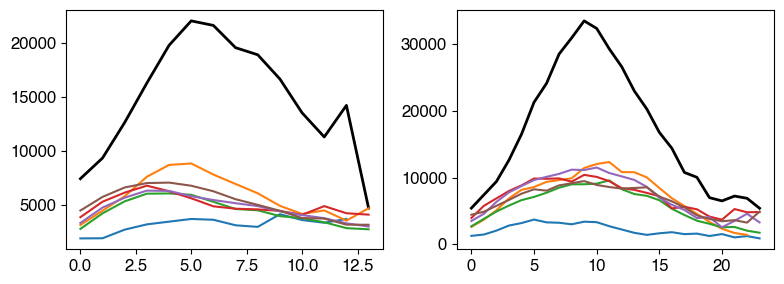

In [62]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_pfarea_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg1_pfarea_o_m1)
ax.plot(xx_m1, avg1_pfarea_o_m2)
ax.plot(xx_m1, avg1_pfarea_o_m3)
ax.plot(xx_m1, avg1_pfarea_o_m4)
ax.plot(xx_m1, avg1_pfarea_o_m5)
ax.plot(xx_m1, avg1_pfarea_o_m6)
ax = axes[1]
ax.plot(xx_obs, avg2_pfarea_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg2_pfarea_o_m1)
ax.plot(xx_m1, avg2_pfarea_o_m2)
ax.plot(xx_m1, avg2_pfarea_o_m3)
ax.plot(xx_m1, avg2_pfarea_o_m4)
ax.plot(xx_m1, avg2_pfarea_o_m5)
ax.plot(xx_m1, avg2_pfarea_o_m6)
fig.tight_layout()

#### Max rain rate (ocean)

In [63]:
avg1_maxrr_o_obs, qntl1_maxrr_o_obs, ns1_o_obs = get_comp_tracks_by1cond(ds_nms_o_obs.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_obs, lifetime_range1, quantiles)
avg1_maxrr_o_m1, qntl1_maxrr_o_m1, ns1_o_m1 = get_comp_tracks_by1cond(ds_nms_o_m1.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m1, lifetime_range1, quantiles)
avg1_maxrr_o_m2, qntl1_maxrr_o_m2, ns1_o_m2 = get_comp_tracks_by1cond(ds_nms_o_m2.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m2, lifetime_range1, quantiles)
avg1_maxrr_o_m3, qntl1_maxrr_o_m3, ns1_o_m3 = get_comp_tracks_by1cond(ds_nms_o_m3.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m3, lifetime_range1, quantiles)
avg1_maxrr_o_m4, qntl1_maxrr_o_m4, ns1_o_m4 = get_comp_tracks_by1cond(ds_nms_o_m4.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m4, lifetime_range1, quantiles)
avg1_maxrr_o_m5, qntl1_maxrr_o_m5, ns1_o_m5 = get_comp_tracks_by1cond(ds_nms_o_m5.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m5, lifetime_range1, quantiles)
avg1_maxrr_o_m6, qntl1_maxrr_o_m6, ns1_o_m6 = get_comp_tracks_by1cond(ds_nms_o_m6.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m6, lifetime_range1, quantiles)

avg2_maxrr_o_obs, qntl2_maxrr_o_obs, ns2_o_obs = get_comp_tracks_by1cond(ds_nms_o_obs.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_obs, lifetime_range2, quantiles)
avg2_maxrr_o_m1, qntl2_maxrr_o_m1, ns2_o_m1 = get_comp_tracks_by1cond(ds_nms_o_m1.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m1, lifetime_range2, quantiles)
avg2_maxrr_o_m2, qntl2_maxrr_o_m2, ns2_o_m2 = get_comp_tracks_by1cond(ds_nms_o_m2.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m2, lifetime_range2, quantiles)
avg2_maxrr_o_m3, qntl2_maxrr_o_m3, ns2_o_m3 = get_comp_tracks_by1cond(ds_nms_o_m3.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m3, lifetime_range2, quantiles)
avg2_maxrr_o_m4, qntl2_maxrr_o_m4, ns2_o_m4 = get_comp_tracks_by1cond(ds_nms_o_m4.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m4, lifetime_range2, quantiles)
avg2_maxrr_o_m5, qntl2_maxrr_o_m5, ns2_o_m5 = get_comp_tracks_by1cond(ds_nms_o_m5.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m5, lifetime_range2, quantiles)
avg2_maxrr_o_m6, qntl2_maxrr_o_m6, ns2_o_m6 = get_comp_tracks_by1cond(ds_nms_o_m6.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_o_m6, lifetime_range2, quantiles)

#### Max rain rate (land)

In [64]:
avg1_maxrr_l_obs, qntl1_maxrr_l_obs, ns1_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range1, quantiles)
avg1_maxrr_l_m1, qntl1_maxrr_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range1, quantiles)
avg1_maxrr_l_m2, qntl1_maxrr_l_m2, ns1_l_m2 = get_comp_tracks_by1cond(ds_nms_l_m2.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m2, lifetime_range1, quantiles)
avg1_maxrr_l_m3, qntl1_maxrr_l_m3, ns1_l_m3 = get_comp_tracks_by1cond(ds_nms_l_m3.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m3, lifetime_range1, quantiles)
avg1_maxrr_l_m4, qntl1_maxrr_l_m4, ns1_l_m4 = get_comp_tracks_by1cond(ds_nms_l_m4.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m4, lifetime_range1, quantiles)
avg1_maxrr_l_m5, qntl1_maxrr_l_m5, ns1_l_m5 = get_comp_tracks_by1cond(ds_nms_l_m5.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m5, lifetime_range1, quantiles)
avg1_maxrr_l_m6, qntl1_maxrr_l_m6, ns1_l_m6 = get_comp_tracks_by1cond(ds_nms_l_m6.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m6, lifetime_range1, quantiles)

avg2_maxrr_l_obs, qntl2_maxrr_l_obs, ns2_l_obs = get_comp_tracks_by1cond(ds_nms_l_obs.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_obs, lifetime_range2, quantiles)
avg2_maxrr_l_m1, qntl2_maxrr_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(ds_nms_l_m1.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m1, lifetime_range2, quantiles)
avg2_maxrr_l_m2, qntl2_maxrr_l_m2, ns2_l_m2 = get_comp_tracks_by1cond(ds_nms_l_m2.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m2, lifetime_range2, quantiles)
avg2_maxrr_l_m3, qntl2_maxrr_l_m3, ns2_l_m3 = get_comp_tracks_by1cond(ds_nms_l_m3.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m3, lifetime_range2, quantiles)
avg2_maxrr_l_m4, qntl2_maxrr_l_m4, ns2_l_m4 = get_comp_tracks_by1cond(ds_nms_l_m4.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m4, lifetime_range2, quantiles)
avg2_maxrr_l_m5, qntl2_maxrr_l_m5, ns2_l_m5 = get_comp_tracks_by1cond(ds_nms_l_m5.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m5, lifetime_range2, quantiles)
avg2_maxrr_l_m6, qntl2_maxrr_l_m6, ns2_l_m6 = get_comp_tracks_by1cond(ds_nms_l_m6.pf_maxrainrate.isel(nmaxpf=0), ccslifetime_l_m6, lifetime_range2, quantiles)

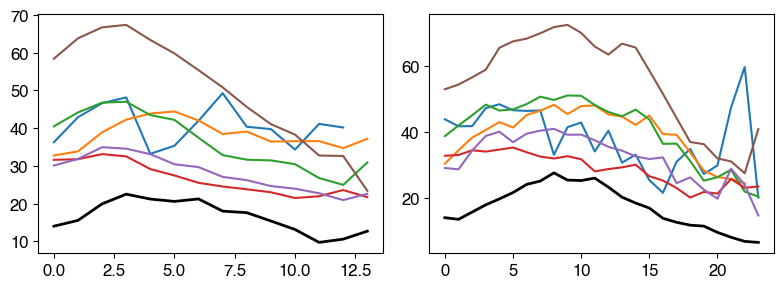

In [65]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_maxrr_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg1_maxrr_o_m1)
ax.plot(xx_m1, avg1_maxrr_o_m2)
ax.plot(xx_m1, avg1_maxrr_o_m3)
ax.plot(xx_m1, avg1_maxrr_o_m4)
ax.plot(xx_m1, avg1_maxrr_o_m5)
ax.plot(xx_m1, avg1_maxrr_o_m6)
ax = axes[1]
ax.plot(xx_obs, avg2_maxrr_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg2_maxrr_o_m1)
ax.plot(xx_m1, avg2_maxrr_o_m2)
ax.plot(xx_m1, avg2_maxrr_o_m3)
ax.plot(xx_m1, avg2_maxrr_o_m4)
ax.plot(xx_m1, avg2_maxrr_o_m5)
ax.plot(xx_m1, avg2_maxrr_o_m6)
fig.tight_layout()

#### PF volume rain (ocean)

In [66]:
# Compute volume rainrate [unit: kg/h]
pfvolrain_o_obs = (ds_nms_o_obs.total_rain * pixel_radius_obs**2)
pfvolrain_o_m1 = (ds_nms_o_m1.total_rain * pixel_radius_m1**2)
pfvolrain_o_m2 = (ds_nms_o_m2.total_rain * pixel_radius_m2**2)
pfvolrain_o_m3 = (ds_nms_o_m3.total_rain * pixel_radius_m3**2)
pfvolrain_o_m4 = (ds_nms_o_m4.total_rain * pixel_radius_m4**2)
pfvolrain_o_m5 = (ds_nms_o_m5.total_rain * pixel_radius_m5**2)
pfvolrain_o_m6 = (ds_nms_o_m6.total_rain * pixel_radius_m6**2)

pfvolrainheavy_o_obs = (ds_nms_o_obs.total_heavyrain * pixel_radius_obs**2)
pfvolrainheavy_o_m1 = (ds_nms_o_m1.total_heavyrain * pixel_radius_m1**2)
pfvolrainheavy_o_m2 = (ds_nms_o_m2.total_heavyrain * pixel_radius_m2**2)
pfvolrainheavy_o_m3 = (ds_nms_o_m3.total_heavyrain * pixel_radius_m3**2)
pfvolrainheavy_o_m4 = (ds_nms_o_m4.total_heavyrain * pixel_radius_m4**2)
pfvolrainheavy_o_m5 = (ds_nms_o_m5.total_heavyrain * pixel_radius_m5**2)
pfvolrainheavy_o_m6 = (ds_nms_o_m6.total_heavyrain * pixel_radius_m6**2)

# Heavy rain volume
avg1_hvr_o_obs, qntl1_hvr_o_obs, ns1_o_obs = get_comp_tracks_by1cond(pfvolrainheavy_o_obs, ccslifetime_o_obs, lifetime_range1, quantiles)
avg1_hvr_o_m1, qntl1_hvr_o_m1, ns1_o_m1 = get_comp_tracks_by1cond(pfvolrainheavy_o_m1, ccslifetime_o_m1, lifetime_range1, quantiles)
avg1_hvr_o_m2, qntl1_hvr_o_m2, ns1_o_m2 = get_comp_tracks_by1cond(pfvolrainheavy_o_m2, ccslifetime_o_m2, lifetime_range1, quantiles)
avg1_hvr_o_m3, qntl1_hvr_o_m3, ns1_o_m3 = get_comp_tracks_by1cond(pfvolrainheavy_o_m3, ccslifetime_o_m3, lifetime_range1, quantiles)
avg1_hvr_o_m4, qntl1_hvr_o_m4, ns1_o_m4 = get_comp_tracks_by1cond(pfvolrainheavy_o_m4, ccslifetime_o_m4, lifetime_range1, quantiles)
avg1_hvr_o_m5, qntl1_hvr_o_m5, ns1_o_m5 = get_comp_tracks_by1cond(pfvolrainheavy_o_m5, ccslifetime_o_m5, lifetime_range1, quantiles)
avg1_hvr_o_m6, qntl1_hvr_o_m6, ns1_o_m6 = get_comp_tracks_by1cond(pfvolrainheavy_o_m6, ccslifetime_o_m6, lifetime_range1, quantiles)

avg2_hvr_o_obs, qntl2_hvr_o_obs, ns2_o_obs = get_comp_tracks_by1cond(pfvolrainheavy_o_obs, ccslifetime_o_obs, lifetime_range2, quantiles)
avg2_hvr_o_m1, qntl2_hvr_o_m1, ns2_o_m1 = get_comp_tracks_by1cond(pfvolrainheavy_o_m1, ccslifetime_o_m1, lifetime_range2, quantiles)
avg2_hvr_o_m2, qntl2_hvr_o_m2, ns2_o_m2 = get_comp_tracks_by1cond(pfvolrainheavy_o_m2, ccslifetime_o_m2, lifetime_range2, quantiles)
avg2_hvr_o_m3, qntl2_hvr_o_m3, ns2_o_m3 = get_comp_tracks_by1cond(pfvolrainheavy_o_m3, ccslifetime_o_m3, lifetime_range2, quantiles)
avg2_hvr_o_m4, qntl2_hvr_o_m4, ns2_o_m4 = get_comp_tracks_by1cond(pfvolrainheavy_o_m4, ccslifetime_o_m4, lifetime_range2, quantiles)
avg2_hvr_o_m5, qntl2_hvr_o_m5, ns2_o_m5 = get_comp_tracks_by1cond(pfvolrainheavy_o_m5, ccslifetime_o_m5, lifetime_range2, quantiles)
avg2_hvr_o_m6, qntl2_hvr_o_m6, ns2_o_m6 = get_comp_tracks_by1cond(pfvolrainheavy_o_m6, ccslifetime_o_m6, lifetime_range2, quantiles)

In [67]:
# Total rain volume
avg1_vr_o_obs, qntl1_vr_o_obs, ns1_o_obs = get_comp_tracks_by1cond(pfvolrain_o_obs, ccslifetime_o_obs, lifetime_range1, quantiles)
avg1_vr_o_m1, qntl1_vr_o_m1, ns1_o_m1 = get_comp_tracks_by1cond(pfvolrain_o_m1, ccslifetime_o_m1, lifetime_range1, quantiles)
avg1_vr_o_m2, qntl1_vr_o_m2, ns1_o_m2 = get_comp_tracks_by1cond(pfvolrain_o_m2, ccslifetime_o_m2, lifetime_range1, quantiles)
avg1_vr_o_m3, qntl1_vr_o_m3, ns1_o_m3 = get_comp_tracks_by1cond(pfvolrain_o_m3, ccslifetime_o_m3, lifetime_range1, quantiles)
avg1_vr_o_m4, qntl1_vr_o_m4, ns1_o_m4 = get_comp_tracks_by1cond(pfvolrain_o_m4, ccslifetime_o_m4, lifetime_range1, quantiles)
avg1_vr_o_m5, qntl1_vr_o_m5, ns1_o_m5 = get_comp_tracks_by1cond(pfvolrain_o_m5, ccslifetime_o_m5, lifetime_range1, quantiles)
avg1_vr_o_m6, qntl1_vr_o_m6, ns1_o_m6 = get_comp_tracks_by1cond(pfvolrain_o_m6, ccslifetime_o_m6, lifetime_range1, quantiles)

avg2_vr_o_obs, qntl2_vr_o_obs, ns2_o_obs = get_comp_tracks_by1cond(pfvolrain_o_obs, ccslifetime_o_obs, lifetime_range2, quantiles)
avg2_vr_o_m1, qntl2_vr_o_m1, ns2_o_m1 = get_comp_tracks_by1cond(pfvolrain_o_m1, ccslifetime_o_m1, lifetime_range2, quantiles)
avg2_vr_o_m2, qntl2_vr_o_m2, ns2_o_m2 = get_comp_tracks_by1cond(pfvolrain_o_m2, ccslifetime_o_m2, lifetime_range2, quantiles)
avg2_vr_o_m3, qntl2_vr_o_m3, ns2_o_m3 = get_comp_tracks_by1cond(pfvolrain_o_m3, ccslifetime_o_m3, lifetime_range2, quantiles)
avg2_vr_o_m4, qntl2_vr_o_m4, ns2_o_m4 = get_comp_tracks_by1cond(pfvolrain_o_m4, ccslifetime_o_m4, lifetime_range2, quantiles)
avg2_vr_o_m5, qntl2_vr_o_m5, ns2_o_m5 = get_comp_tracks_by1cond(pfvolrain_o_m5, ccslifetime_o_m5, lifetime_range2, quantiles)
avg2_vr_o_m6, qntl2_vr_o_m6, ns2_o_m6 = get_comp_tracks_by1cond(pfvolrain_o_m6, ccslifetime_o_m6, lifetime_range2, quantiles)

#### PF volume rain (land)

In [68]:
# Compute volume rainrate [unit: kg/h]
pfvolrain_l_obs = (ds_nms_l_obs.total_rain * pixel_radius_obs**2)
pfvolrain_l_m1 = (ds_nms_l_m1.total_rain * pixel_radius_m1**2)
pfvolrain_l_m2 = (ds_nms_l_m2.total_rain * pixel_radius_m2**2)
pfvolrain_l_m3 = (ds_nms_l_m3.total_rain * pixel_radius_m3**2)
pfvolrain_l_m4 = (ds_nms_l_m4.total_rain * pixel_radius_m4**2)
pfvolrain_l_m5 = (ds_nms_l_m5.total_rain * pixel_radius_m5**2)
pfvolrain_l_m6 = (ds_nms_l_m6.total_rain * pixel_radius_m6**2)

# Total rain volume
avg1_vr_l_obs, qntl1_vr_l_obs, ns1_l_obs = get_comp_tracks_by1cond(pfvolrain_l_obs, ccslifetime_l_obs, lifetime_range1, quantiles)
avg1_vr_l_m1, qntl1_vr_l_m1, ns1_l_m1 = get_comp_tracks_by1cond(pfvolrain_l_m1, ccslifetime_l_m1, lifetime_range1, quantiles)
avg1_vr_l_m2, qntl1_vr_l_m2, ns1_l_m2 = get_comp_tracks_by1cond(pfvolrain_l_m2, ccslifetime_l_m2, lifetime_range1, quantiles)
avg1_vr_l_m3, qntl1_vr_l_m3, ns1_l_m3 = get_comp_tracks_by1cond(pfvolrain_l_m3, ccslifetime_l_m3, lifetime_range1, quantiles)
avg1_vr_l_m4, qntl1_vr_l_m4, ns1_l_m4 = get_comp_tracks_by1cond(pfvolrain_l_m4, ccslifetime_l_m4, lifetime_range1, quantiles)
avg1_vr_l_m5, qntl1_vr_l_m5, ns1_l_m5 = get_comp_tracks_by1cond(pfvolrain_l_m5, ccslifetime_l_m5, lifetime_range1, quantiles)
avg1_vr_l_m6, qntl1_vr_l_m6, ns1_l_m6 = get_comp_tracks_by1cond(pfvolrain_l_m6, ccslifetime_l_m6, lifetime_range1, quantiles)

avg2_vr_l_obs, qntl2_vr_l_obs, ns2_l_obs = get_comp_tracks_by1cond(pfvolrain_l_obs, ccslifetime_l_obs, lifetime_range2, quantiles)
avg2_vr_l_m1, qntl2_vr_l_m1, ns2_l_m1 = get_comp_tracks_by1cond(pfvolrain_l_m1, ccslifetime_l_m1, lifetime_range2, quantiles)
avg2_vr_l_m2, qntl2_vr_l_m2, ns2_l_m2 = get_comp_tracks_by1cond(pfvolrain_l_m2, ccslifetime_l_m2, lifetime_range2, quantiles)
avg2_vr_l_m3, qntl2_vr_l_m3, ns2_l_m3 = get_comp_tracks_by1cond(pfvolrain_l_m3, ccslifetime_l_m3, lifetime_range2, quantiles)
avg2_vr_l_m4, qntl2_vr_l_m4, ns2_l_m4 = get_comp_tracks_by1cond(pfvolrain_l_m4, ccslifetime_l_m4, lifetime_range2, quantiles)
avg2_vr_l_m5, qntl2_vr_l_m5, ns2_l_m5 = get_comp_tracks_by1cond(pfvolrain_l_m5, ccslifetime_l_m5, lifetime_range2, quantiles)
avg2_vr_l_m6, qntl2_vr_l_m6, ns2_l_m6 = get_comp_tracks_by1cond(pfvolrain_l_m6, ccslifetime_l_m6, lifetime_range2, quantiles)

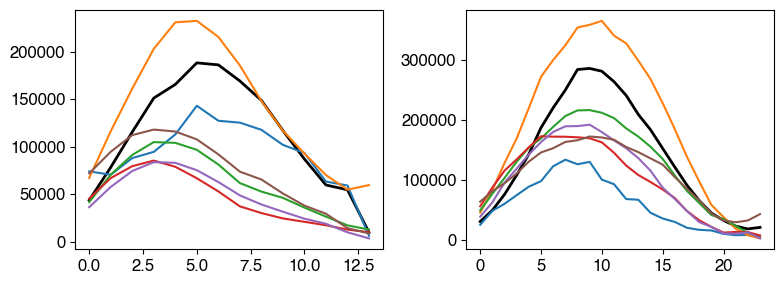

In [69]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_vr_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg1_vr_o_m1)
ax.plot(xx_m1, avg1_vr_o_m2)
ax.plot(xx_m1, avg1_vr_o_m3)
ax.plot(xx_m1, avg1_vr_o_m4)
ax.plot(xx_m1, avg1_vr_o_m5)
ax.plot(xx_m1, avg1_vr_o_m6)
ax = axes[1]
ax.plot(xx_obs, avg2_vr_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg2_vr_o_m1)
ax.plot(xx_m1, avg2_vr_o_m2)
ax.plot(xx_m1, avg2_vr_o_m3)
ax.plot(xx_m1, avg2_vr_o_m4)
ax.plot(xx_m1, avg2_vr_o_m5)
ax.plot(xx_m1, avg2_vr_o_m6)
fig.tight_layout()

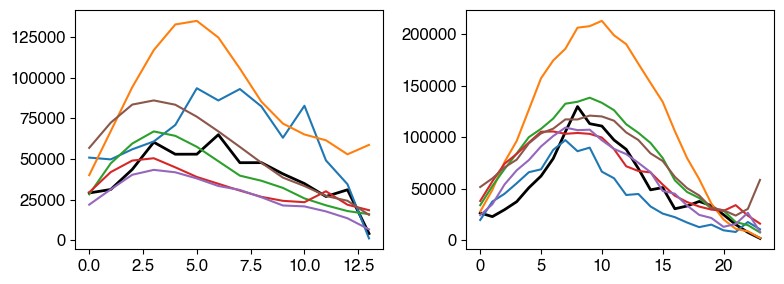

In [70]:
fig, axes = plt.subplots(1, 2, figsize=[8,3], dpi=100)
ax = axes[0]
ax.plot(xx_obs, avg1_hvr_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg1_hvr_o_m1)
ax.plot(xx_m1, avg1_hvr_o_m2)
ax.plot(xx_m1, avg1_hvr_o_m3)
ax.plot(xx_m1, avg1_hvr_o_m4)
ax.plot(xx_m1, avg1_hvr_o_m5)
ax.plot(xx_m1, avg1_hvr_o_m6)
ax = axes[1]
ax.plot(xx_obs, avg2_hvr_o_obs, 'k', lw=2)
ax.plot(xx_m1, avg2_hvr_o_m1)
ax.plot(xx_m1, avg2_hvr_o_m2)
ax.plot(xx_m1, avg2_hvr_o_m3)
ax.plot(xx_m1, avg2_hvr_o_m4)
ax.plot(xx_m1, avg2_hvr_o_m5)
ax.plot(xx_m1, avg2_hvr_o_m6)
fig.tight_layout()

### Set inset map region

In [71]:
map_extent = [lon_bounds[0],lon_bounds[1]-1,lat_bounds[0]-20,lat_bounds[1]+20]
lonbox = [lon_bounds[0], lon_bounds[1]-1]
latbox = [lat_bounds[0], lat_bounds[1]]
map_extent, lonbox, latbox

([0, 359, -40, 35], [0, 359], [-20, 15])

## Function to plot composite evolution

In [72]:
def plot_evolution_mxn(nrow, ncol, bins, data_arr, titles, xlabels, ylabels, legends, figname,  
                        map_extent=None, lonbox=None, latbox=None, inset_param=None, map_panel=[0,0],
                        xscale=None, yscale=None, xlims=None, ylims=None,
                        legend_fontsize=11, legend_loc='best', figsize=[10,10]):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=figsize, dpi=100)

    lw = 2
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'blue',
        'm6': 'purple',
    }

    for row in range(0, nrow):
        for col in range(0, ncol): 
            ax = axes[row][col]           
            ax.plot(bins['obs'], data_arr[row][col]['obs'], lcolors['obs'], lw=lw*3, label=legends[col]['obs'])
            qntl25 = data_arr[row][col]['obs_qntl'].sel(quantile=0.25)
            qntl75 = data_arr[row][col]['obs_qntl'].sel(quantile=0.75)
            ax.fill_between(bins['obs'], qntl25, qntl75, facecolor=lcolors['obs'], alpha=0.3)
            ax.plot(bins['m1'], data_arr[row][col]['m1'], lcolors['m1'], lw=lw, label=legends[col]['m1'])
            ax.plot(bins['m2'], data_arr[row][col]['m2'], lcolors['m2'], lw=lw, label=legends[col]['m2'])
            ax.plot(bins['m3'], data_arr[row][col]['m3'], lcolors['m3'], lw=lw, label=legends[col]['m3'])
            ax.plot(bins['m4'], data_arr[row][col]['m4'], lcolors['m4'], lw=lw, label=legends[col]['m4'])
            ax.plot(bins['m5'], data_arr[row][col]['m5'], lcolors['m5'], lw=lw, label=legends[col]['m5'])
            ax.plot(bins['m6'], data_arr[row][col]['m6'], lcolors['m6'], lw=lw, label=legends[col]['m6'])
            # Labels
            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            # Draw an arrow to show the direction of time increase
            if (row == nrow-1):
                ax.annotate('', xy=(1, -0.25), xytext=(0, -0.25), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))

            # Plot inset map
            if (row == map_panel[0]) & (col == map_panel[1]):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                # borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                # sub_ax.add_feature(borders, edgecolor=lcolors['obs'], facecolor='none', zorder=4)
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=4)
                # Plot a box region in the inset
                box = sgeom.box(minx=lonbox[0], maxx=lonbox[1], miny=latbox[0], maxy=latbox[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.8, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

<ipython-input-72-b242d95e9081>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


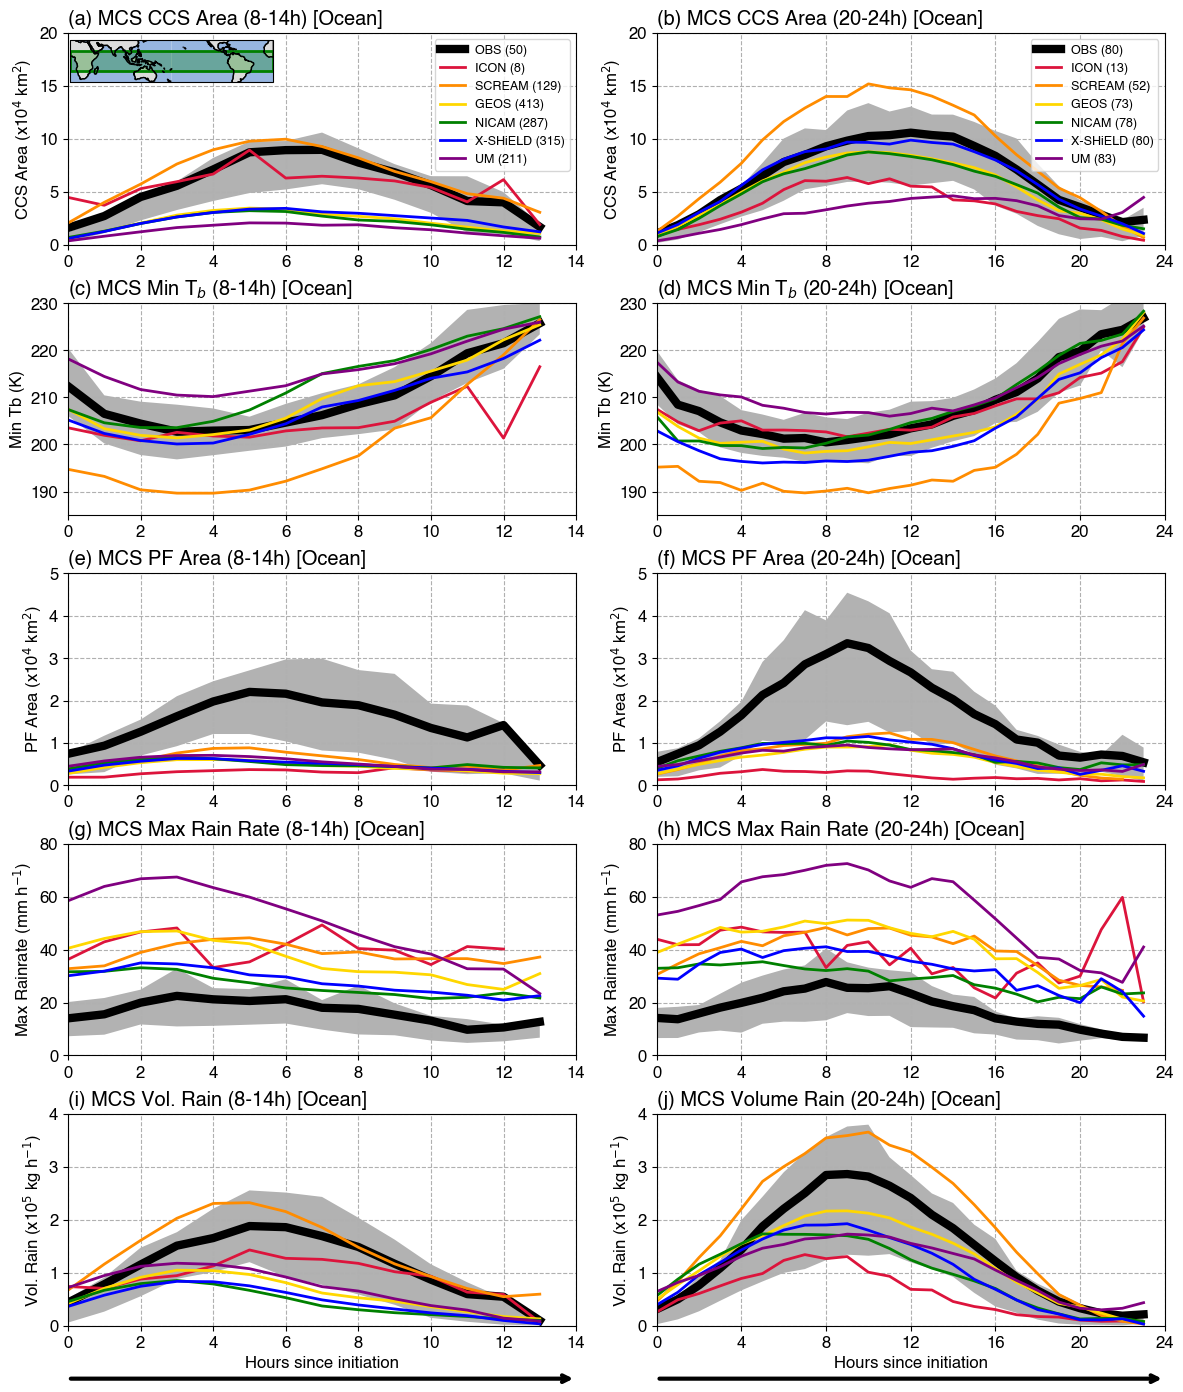

In [75]:
bins = {
    'obs': xx_obs,
    'm1': xx_m1,
    'm2': xx_m2,
    'm3': xx_m3,
    'm4': xx_m4,
    'm5': xx_m5,
    'm6': xx_m6,
}
ccsarea1_dict = {
    'obs': avg1_ccsarea_o_obs/1e4,
    'obs_qntl': qntl1_ccsarea_o_obs/1e4,
    'm1': avg1_ccsarea_o_m1/1e4,
    'm2': avg1_ccsarea_o_m2/1e4,
    'm3': avg1_ccsarea_o_m3/1e4,
    'm4': avg1_ccsarea_o_m4/1e4,
    'm5': avg1_ccsarea_o_m5/1e4,
    'm6': avg1_ccsarea_o_m6/1e4,
}
ccsarea2_dict = {
    'obs': avg2_ccsarea_o_obs/1e4,
    'obs_qntl': qntl2_ccsarea_o_obs/1e4,
    'm1': avg2_ccsarea_o_m1/1e4,
    'm2': avg2_ccsarea_o_m2/1e4,
    'm3': avg2_ccsarea_o_m3/1e4,
    'm4': avg2_ccsarea_o_m4/1e4,
    'm5': avg2_ccsarea_o_m5/1e4,
    'm6': avg2_ccsarea_o_m6/1e4,
}
mintb1_dict = {
    'obs': avg1_mintb_o_obs,
    'obs_qntl': qntl1_mintb_o_obs,
    'm1': avg1_mintb_o_m1,
    'm2': avg1_mintb_o_m2,
    'm3': avg1_mintb_o_m3,
    'm4': avg1_mintb_o_m4,
    'm5': avg1_mintb_o_m5,
    'm6': avg1_mintb_o_m6,
}
mintb2_dict = {
    'obs': avg2_mintb_o_obs,
    'obs_qntl': qntl2_mintb_o_obs,
    'm1': avg2_mintb_o_m1,
    'm2': avg2_mintb_o_m2,
    'm3': avg2_mintb_o_m3,
    'm4': avg2_mintb_o_m4,
    'm5': avg2_mintb_o_m5,
    'm6': avg2_mintb_o_m6,
}
pfarea1_dict = {
    'obs': avg1_pfarea_o_obs/1e4,
    'obs_qntl': qntl1_pfarea_o_obs/1e4,
    'm1': avg1_pfarea_o_m1/1e4,
    'm2': avg1_pfarea_o_m2/1e4,
    'm3': avg1_pfarea_o_m3/1e4,
    'm4': avg1_pfarea_o_m4/1e4,
    'm5': avg1_pfarea_o_m5/1e4,
    'm6': avg1_pfarea_o_m6/1e4,
}
pfarea2_dict = {
    'obs': avg2_pfarea_o_obs/1e4,
    'obs_qntl': qntl2_pfarea_o_obs/1e4,
    'm1': avg2_pfarea_o_m1/1e4,
    'm2': avg2_pfarea_o_m2/1e4,
    'm3': avg2_pfarea_o_m3/1e4,
    'm4': avg2_pfarea_o_m4/1e4,
    'm5': avg2_pfarea_o_m5/1e4,
    'm6': avg2_pfarea_o_m6/1e4,
}
maxrr1_dict = {
    'obs': avg1_maxrr_o_obs,
    'obs_qntl': qntl1_maxrr_o_obs,
    'm1': avg1_maxrr_o_m1,
    'm2': avg1_maxrr_o_m2,
    'm3': avg1_maxrr_o_m3,
    'm4': avg1_maxrr_o_m4,
    'm5': avg1_maxrr_o_m5,
    'm6': avg1_maxrr_o_m6,
}
maxrr2_dict = {
    'obs': avg2_maxrr_o_obs,
    'obs_qntl': qntl2_maxrr_o_obs,
    'm1': avg2_maxrr_o_m1,
    'm2': avg2_maxrr_o_m2,
    'm3': avg2_maxrr_o_m3,
    'm4': avg2_maxrr_o_m4,
    'm5': avg2_maxrr_o_m5,
    'm6': avg2_maxrr_o_m6,
}
volrain1_dict = {
    'obs': avg1_vr_o_obs/1e5,
    'obs_qntl': qntl1_vr_o_obs/1e5,
    'm1': avg1_vr_o_m1/1e5,
    'm2': avg1_vr_o_m2/1e5,
    'm3': avg1_vr_o_m3/1e5,
    'm4': avg1_vr_o_m4/1e5,
    'm5': avg1_vr_o_m5/1e5,
    'm6': avg1_vr_o_m6/1e5,
}
volrain2_dict = {
    'obs': avg2_vr_o_obs/1e5,
    'obs_qntl': qntl2_vr_o_obs/1e5,
    'm1': avg2_vr_o_m1/1e5,
    'm2': avg2_vr_o_m2/1e5,
    'm3': avg2_vr_o_m3/1e5,
    'm4': avg2_vr_o_m4/1e5,
    'm5': avg2_vr_o_m5/1e5,
    'm6': avg2_vr_o_m6/1e5,
}
legends1 = {
    'obs': f'{model_name[name_map["obs"]]} ({ns1_o_obs})',
    'm1': f'{model_name[name_map["m1"]]} ({ns1_o_m1})',
    'm2': f'{model_name[name_map["m2"]]} ({ns1_o_m2})',
    'm3': f'{model_name[name_map["m3"]]} ({ns1_o_m3})',
    'm4': f'{model_name[name_map["m4"]]} ({ns1_o_m4})',
    'm5': f'{model_name[name_map["m5"]]} ({ns1_o_m5})',
    'm6': f'{model_name[name_map["m6"]]} ({ns1_o_m6})',
}
legends2 = {
    'obs': f'{model_name[name_map["obs"]]} ({ns2_o_obs})',
    'm1': f'{model_name[name_map["m1"]]} ({ns2_o_m1})',
    'm2': f'{model_name[name_map["m2"]]} ({ns2_o_m2})',
    'm3': f'{model_name[name_map["m3"]]} ({ns2_o_m3})',
    'm4': f'{model_name[name_map["m4"]]} ({ns2_o_m4})',
    'm5': f'{model_name[name_map["m5"]]} ({ns2_o_m5})',
    'm6': f'{model_name[name_map["m6"]]} ({ns2_o_m6})',
}

data_arr = [
    [ccsarea1_dict, ccsarea2_dict,], 
    [mintb1_dict, mintb2_dict,],
    [pfarea1_dict,pfarea2_dict],
    [maxrr1_dict, maxrr2_dict],
    [volrain1_dict,volrain2_dict],
]
legends = [legends1, legends2]
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Ocean]', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Ocean]'],
          [f'(c) MCS Min T$_b$ ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Ocean]', f'(d) MCS Min T$_b$ ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Ocean]'],
          [f'(e) MCS PF Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Ocean]', f'(f) MCS PF Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Ocean]'],
          [f'(g) MCS Max Rain Rate ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Ocean]', f'(h) MCS Max Rain Rate ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Ocean]'],
          [f'(i) MCS Vol. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Ocean]', f'(j) MCS Volume Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Ocean]']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Area (x10$^{4}$ km$^2$)', 'Max Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,20), (185,230), (0,5), (0,80), (0,4)]
inset_param = {'width':'40%', 'height':'25%', 'loc':'upper left', 'borderpad':0.1}
figname = f'{figdir}mcs_composite_evolution_{region}_ocean.png'
fig = plot_evolution_mxn(5, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xlims=xlims, ylims=ylims,
                   legend_fontsize=9, legend_loc='best', figsize=[12,14])

## Land

<ipython-input-72-b242d95e9081>:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.8, h_pad=0.5)


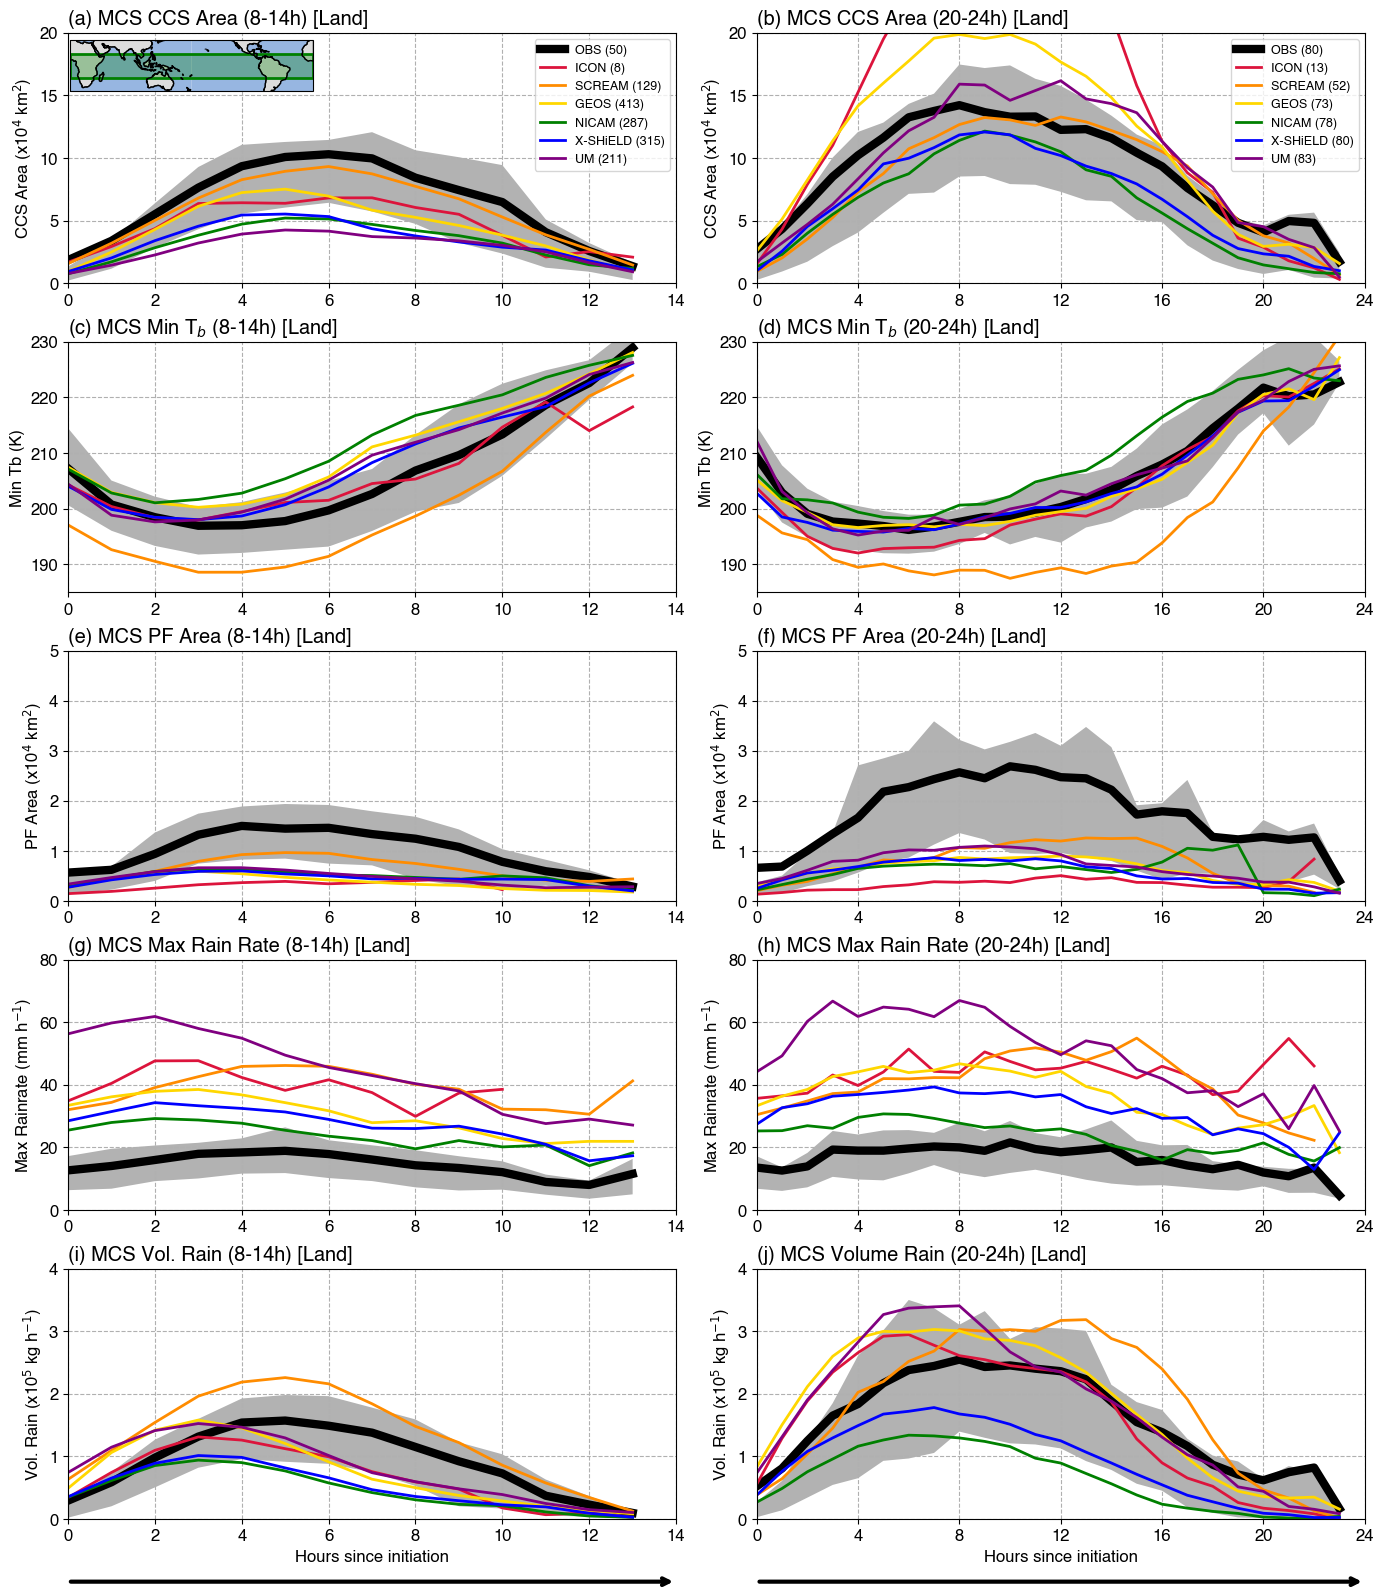

In [76]:
bins = {
    'obs': xx_obs,
    'm1': xx_m1,
    'm2': xx_m2,
    'm3': xx_m3,
    'm4': xx_m4,
    'm5': xx_m5,
    'm6': xx_m6,
}
ccsarea1_dict = {
    'obs': avg1_ccsarea_l_obs/1e4,
    'obs_qntl': qntl1_ccsarea_l_obs/1e4,
    'm1': avg1_ccsarea_l_m1/1e4,
    'm2': avg1_ccsarea_l_m2/1e4,
    'm3': avg1_ccsarea_l_m3/1e4,
    'm4': avg1_ccsarea_l_m4/1e4,
    'm5': avg1_ccsarea_l_m5/1e4,
    'm6': avg1_ccsarea_l_m6/1e4,
}
ccsarea2_dict = {
    'obs': avg2_ccsarea_l_obs/1e4,
    'obs_qntl': qntl2_ccsarea_l_obs/1e4,
    'm1': avg2_ccsarea_l_m1/1e4,
    'm2': avg2_ccsarea_l_m2/1e4,
    'm3': avg2_ccsarea_l_m3/1e4,
    'm4': avg2_ccsarea_l_m4/1e4,
    'm5': avg2_ccsarea_l_m5/1e4,
    'm6': avg2_ccsarea_l_m6/1e4,
}
mintb1_dict = {
    'obs': avg1_mintb_l_obs,
    'obs_qntl': qntl1_mintb_l_obs,
    'm1': avg1_mintb_l_m1,
    'm2': avg1_mintb_l_m2,
    'm3': avg1_mintb_l_m3,
    'm4': avg1_mintb_l_m4,
    'm5': avg1_mintb_l_m5,
    'm6': avg1_mintb_l_m6,
}
mintb2_dict = {
    'obs': avg2_mintb_l_obs,
    'obs_qntl': qntl2_mintb_l_obs,
    'm1': avg2_mintb_l_m1,
    'm2': avg2_mintb_l_m2,
    'm3': avg2_mintb_l_m3,
    'm4': avg2_mintb_l_m4,
    'm5': avg2_mintb_l_m5,
    'm6': avg2_mintb_l_m6,
}
pfarea1_dict = {
    'obs': avg1_pfarea_l_obs/1e4,
    'obs_qntl': qntl1_pfarea_l_obs/1e4,
    'm1': avg1_pfarea_l_m1/1e4,
    'm2': avg1_pfarea_l_m2/1e4,
    'm3': avg1_pfarea_l_m3/1e4,
    'm4': avg1_pfarea_l_m4/1e4,
    'm5': avg1_pfarea_l_m5/1e4,
    'm6': avg1_pfarea_l_m6/1e4,
}
pfarea2_dict = {
    'obs': avg2_pfarea_l_obs/1e4,
    'obs_qntl': qntl2_pfarea_l_obs/1e4,
    'm1': avg2_pfarea_l_m1/1e4,
    'm2': avg2_pfarea_l_m2/1e4,
    'm3': avg2_pfarea_l_m3/1e4,
    'm4': avg2_pfarea_l_m4/1e4,
    'm5': avg2_pfarea_l_m5/1e4,
    'm6': avg2_pfarea_l_m6/1e4,
}
maxrr1_dict = {
    'obs': avg1_maxrr_l_obs,
    'obs_qntl': qntl1_maxrr_l_obs,
    'm1': avg1_maxrr_l_m1,
    'm2': avg1_maxrr_l_m2,
    'm3': avg1_maxrr_l_m3,
    'm4': avg1_maxrr_l_m4,
    'm5': avg1_maxrr_l_m5,
    'm6': avg1_maxrr_l_m6,
}
maxrr2_dict = {
    'obs': avg2_maxrr_l_obs,
    'obs_qntl': qntl2_maxrr_l_obs,
    'm1': avg2_maxrr_l_m1,
    'm2': avg2_maxrr_l_m2,
    'm3': avg2_maxrr_l_m3,
    'm4': avg2_maxrr_l_m4,
    'm5': avg2_maxrr_l_m5,
    'm6': avg2_maxrr_l_m6,
}
volrain1_dict = {
    'obs': avg1_vr_l_obs/1e5,
    'obs_qntl': qntl1_vr_l_obs/1e5,
    'm1': avg1_vr_l_m1/1e5,
    'm2': avg1_vr_l_m2/1e5,
    'm3': avg1_vr_l_m3/1e5,
    'm4': avg1_vr_l_m4/1e5,
    'm5': avg1_vr_l_m5/1e5,
    'm6': avg1_vr_l_m6/1e5,
}
volrain2_dict = {
    'obs': avg2_vr_l_obs/1e5,
    'obs_qntl': qntl2_vr_l_obs/1e5,
    'm1': avg2_vr_l_m1/1e5,
    'm2': avg2_vr_l_m2/1e5,
    'm3': avg2_vr_l_m3/1e5,
    'm4': avg2_vr_l_m4/1e5,
    'm5': avg2_vr_l_m5/1e5,
    'm6': avg2_vr_l_m6/1e5,
}

data_arr = [
    [ccsarea1_dict, ccsarea2_dict,], 
    [mintb1_dict, mintb2_dict,],
    [pfarea1_dict,pfarea2_dict],
    [maxrr1_dict, maxrr2_dict],
    [volrain1_dict,volrain2_dict],
]
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Land]', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Land]'],
          [f'(c) MCS Min T$_b$ ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Land]', f'(d) MCS Min T$_b$ ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Land]'],
          [f'(e) MCS PF Area ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Land]', f'(f) MCS PF Area ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Land]'],
          [f'(g) MCS Max Rain Rate ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Land]', f'(h) MCS Max Rain Rate ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Land]'],
          [f'(i) MCS Vol. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h) [Land]', f'(j) MCS Volume Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h) [Land]']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Area (x10$^{4}$ km$^2$)', 'Max Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,20), (185,230), (0,5), (0,80), (0,4)]
inset_param = {'width':'40%', 'height':'25%', 'loc':'upper left', 'borderpad':0.1}
figname = f'{figdir}mcs_composite_evolution_{region}_land.png'
fig = plot_evolution_mxn(5, 2, bins, data_arr, titles, xlabels, ylabels, legends, figname,
                   map_extent=map_extent, lonbox=lonbox, latbox=latbox, inset_param=inset_param, map_panel=[0,0],
                   xlims=xlims, ylims=ylims,
                   legend_fontsize=9, legend_loc='best', figsize=[14,16])